In [2]:
from VR_Trajectory_analysis import *

In [1]:
directory = '/Users/apaula/ownCloud/MatrexVR1/20241203_TM_Ants_Grey_patch1_Data/RunData'
directory = '/Users/apaula/ownCloud/MatrexVR1/20241213_ants_size_bias_Data/RunData'

In [ ]:
df = get_combined_df(directory, trim_seconds=1.0)

In [3]:
import os
import json
import glob
import pandas as pd

def get_combined_df(directory: str, trim_seconds: float = 1.0) -> pd.DataFrame:
    """
    Recursively load and process CSV files from subdirectories and combine into a single DataFrame,
    incorporating metadata from the JSON file in each directory.
    """
    subdirectories = [
        os.path.join(directory, d) 
        for d in os.listdir(directory) 
        if os.path.isdir(os.path.join(directory, d))
    ]

    if not subdirectories:
        print(f"No subdirectories found in directory: {directory}")
        return pd.DataFrame()
    
    combined_dfs = []
    for subdir in subdirectories:
        subfolder_name = os.path.basename(subdir)
        print(f"Processing subfolder: {subfolder_name}")

        # 1. Identify the metadata JSON in the current folder
        metadata_files = glob.glob(os.path.join(subdir, '*_FlyMetaData.json'))
        metadata = None
        if metadata_files:
            # If there are multiple, just pick the first or handle accordingly
            meta_path = metadata_files[0]
            with open(meta_path, 'r') as f:
                metadata = json.load(f)
        else:
            print(f"No JSON metadata file found in subfolder: {subdir}")

        # 2. Parse the relevant fields from the metadata
        experimenter_name = None
        comments = None
        vr_fly_map = {}  # Will map "VR1" -> "FlyID"

        if metadata:
            experimenter_name = metadata.get("ExperimenterName", "")
            comments = metadata.get("Comments", "")
            flies_info = metadata.get("Flies", [])  # list of dicts

            # Build a dict for VR -> FlyID mapping
            for dct in flies_info:
                # dct might look like {"VR": "VR1", "FlyID": "41", ...}
                vr = dct.get("VR")
                fly_id = dct.get("FlyID")
                if vr and fly_id:
                    vr_fly_map[vr] = fly_id

        # 3. Load all CSVs in subfolder
        file_paths = [
            os.path.join(subdir, f) 
            for f in os.listdir(subdir) 
            if f.endswith('.csv')
        ]
        if not file_paths:
            print(f"No CSV files found in subfolder: {subdir}")
            continue

        dfs = []
        for csv_path in file_paths:
            df_loaded = load_csv(csv_path)
            df_processed = process_dataframe(df_loaded, trim_seconds)
            if df_processed.empty:
                print(f"No data loaded from {csv_path}")
                continue

            # 4. Add metadata columns if available
            if metadata:
                # Add the same experimenter name and comments to every row
                df_processed["ExperimenterName"] = experimenter_name
                df_processed["Comments"] = comments

                # Map VR -> FlyID
                # (If a particular VR doesn't exist in vr_fly_map, result will be NaN)
                df_processed["FlyID"] = df_processed["VR"].map(vr_fly_map)
            
            dfs.append(df_processed)

        if not dfs:
            print(f"No data frames were loaded for subfolder: {subfolder_name}")
            continue

        # 5. Concatenate all CSVs from this subfolder
        combined_df_subfolder = pd.concat(dfs, ignore_index=True)
        combined_dfs.append(combined_df_subfolder)
    
    # 6. Combine data from all subfolders
    if combined_dfs:
        final_df = pd.concat(combined_dfs, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()


# Example usage
df = get_combined_df(directory, trim_seconds=1.0)


Processing subfolder: 20241217_134346
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20241213_ants_size_bias_Data/RunData/20241217_134346/20241217_134346_Forrest_choice_VR2_.csv
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20241213_ants_size_bias_Data/RunData/20241217_134346/20241217_134346_Choice_noBG_VR2_.csv
Processing subfolder: 20241218_154928
Processing subfolder: 20241219_165651
Processing subfolder: 20241219_123109
Processing subfolder: 20241216_152041
Processing subfolder: 20241217_144300
Processing subfolder: 20241216_131139
Processing subfolder: 20241218_142119
Processing subfolder: 20241219_141645
Processing subfolder: 20241216_154615
Processing subfolder: 20241216_113323
Processing subfolder: 20241216_172110
Processing subfolder: 20241218_141804
Processing subfolder: 20241218_132702
Processing subfolder: 20241219_132104
Processing subfolder: 20241218_122444
Processing subfolder: 20241219_112628
Processing subfolder: 20241217_143156
No JSON metadata file found

In [ ]:
df

In [4]:
df = add_trial_id_and_displacement(df)
df = add_trial_time(df)

In [6]:
#remove trials, because they where from a keyboard test
df = df[~df['UniqueTrialID'].isin([0, 1, 2, 3])]

In [5]:
df_stationary, df_normal, df_excessive, stationary_ids, normal_ids, excessive_ids = classify_trials_by_displacement(df[df['Scene']=='Choice_noBG'], min_disp=0, max_disp=500)

In [34]:
forrest_stationary, forrest_normal, forrest_excessive, stationary_ids, normal_ids, excessive_ids = classify_trials_by_displacement(df[df['Scene']=='Forrest_choice'], min_disp=14, max_disp=200)

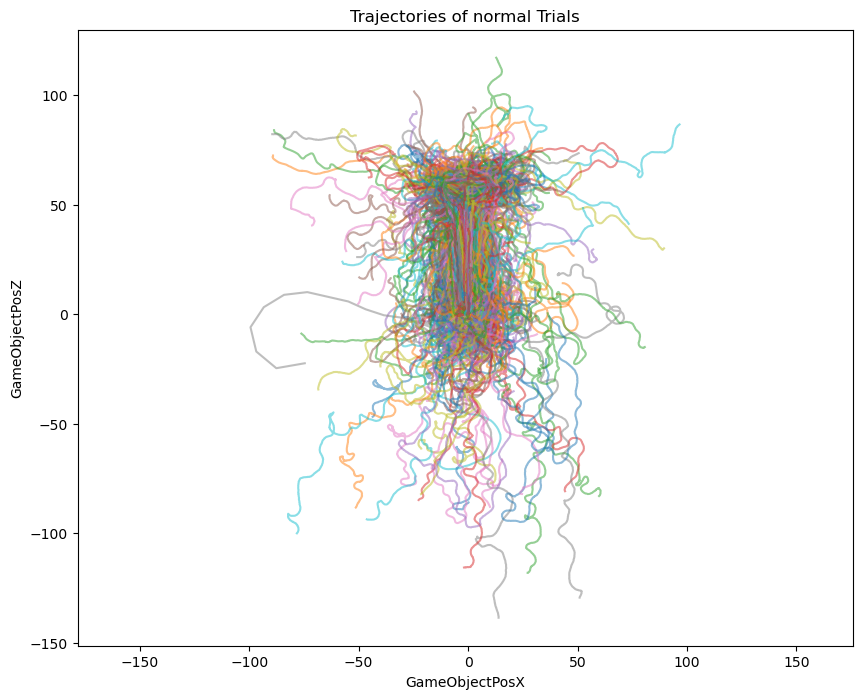

In [6]:
plot_trajectories(df_normal, 'normal')

In [ ]:
plot_trajectories(forrest_normal, 'Forrest')

In [ ]:
plot_trajectories(df_normal[df_normal['UniqueTrialID']==12], 'Normal') 

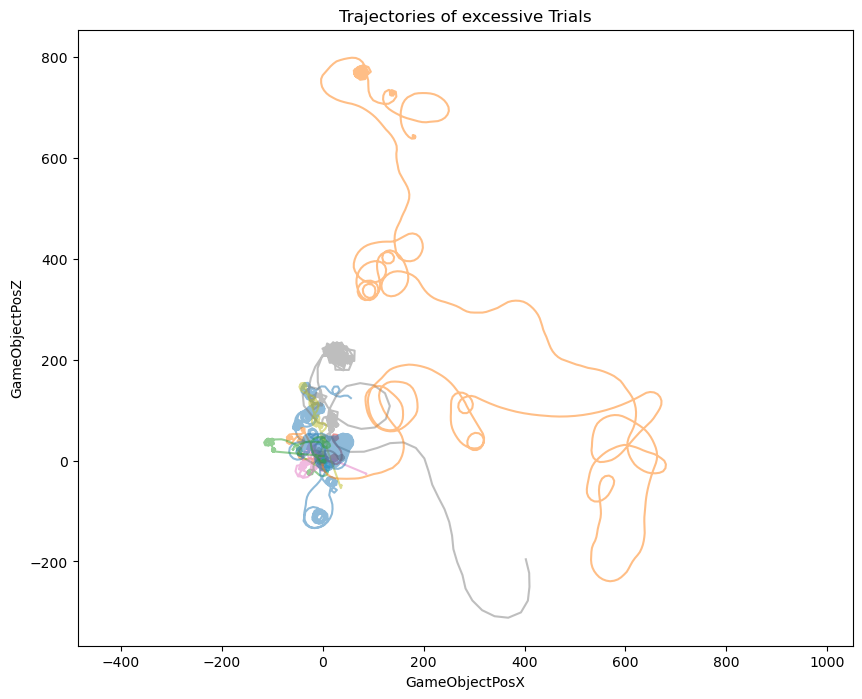

In [7]:
plot_trajectories(df_excessive, 'excessive') 

In [ ]:
df_normal

In [ ]:
# Define goal coordinates (same as before)
center_goal = (0, 60)
left_goal = (-10.416, 59.088)
right_goal = (10.416, 59.088)

# Threshold for reaching the goal
threshold = 4  # 4 cm

# Config files that have only the center goal
center_only_configs = [
    "BinaryChoice10_BlackCylinder_control.json",
    "BinaryChoice10_constantSize_BlackCylinder_control.json"
]

def distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

results = []

for trial_id, trial_data in df_normal.groupby('UniqueTrialID'):
    config = trial_data['ConfigFile'].iloc[0]
    
    # Determine relevant goals
    if config in center_only_configs:
        goals = [('center', center_goal)]
    else:
        goals = [('left', left_goal), ('right', right_goal)]
    
    first_reached = None
    reached_time = None
    
    # Ensure data is time-sorted
    trial_data = trial_data.sort_values(by='trial_time')
    
    for idx, row in trial_data.iterrows():
        participant_pos = (row['GameObjectPosX'], row['GameObjectPosZ'])
        
        # Check each goal
        for goal_name, goal_pos in goals:
            dist = distance(participant_pos, goal_pos)
            if dist <= threshold:
                first_reached = goal_name
                reached_time = row['trial_time']  # store the time at which the goal was reached
                break
        
        if first_reached is not None:
            break
    
    # Append the results including the config file
    results.append((trial_id, config, first_reached, reached_time))

results_df = pd.DataFrame(results, columns=['UniqueTrialID', 'ConfigFile', 'FirstReachedGoal', 'GoalReachedTime'])

print(results_df)

In [9]:
results_df.to_pickle("results_df.pkl")

In [10]:
results_df = pd.read_pickle("results_df.pkl")

In [ ]:
results_df

In [12]:
# Define sets for easier logic
all_black_configs = {
    "BinaryChoice10_BlackCylinder_control.json",
    "BinaryChoice10_constantSize_BlackCylinder_control.json",
    "BinaryChoice11_BlackCylinder_BlackCylinder.json",
    "BinaryChoice11_constantSize_BlackCylinder_BlackCylinder.json"
}

left_grey_right_black_configs = {
    "BinaryChoice31_323232_BlackCylinder.json",
    "BinaryChoice31_constantSize_323232_BlackCylinder.json"
}

left_black_right_grey_configs = {
    "BinaryChoice13_BlackCylinder_323232.json",
    "BinaryChoice13_constantSize_BlackCylinder_323232.json"
}

def goal_type_from_config(config, reached_goal):
    # Configs where all goals are black
    if config in all_black_configs:
        return "black"
    
    # Configs where left=grey, right=black
    if config in left_grey_right_black_configs:
        if reached_goal == "left":
            return "grey"
        elif reached_goal == "right":
            return "black"
        elif reached_goal == "center":
            return None
    
    # Configs where left=black, right=grey
    if config in left_black_right_grey_configs:
        if reached_goal == "left":
            return "black"
        elif reached_goal == "right":
            return "grey"
        elif reached_goal == "center":
            return None
    
    return None

# Add the GoalType column to results_df
results_df['GoalType'] = results_df.apply(
    lambda row: goal_type_from_config(row['ConfigFile'], row['FirstReachedGoal']),
    axis=1
)


In [ ]:
results_df['GoalReachedTime'].describe()


In [ ]:
results_df['GoalReachedTime'].hist()

In [ ]:
# Example: Get the trajectory for a specific trial only until the goal is reached
target_trial_id = 16  # example
trial_info = results_df.loc[results_df['UniqueTrialID'] == target_trial_id]

if not trial_info.empty:
    cutoff_time = trial_info['GoalReachedTime'].iloc[0]
    trial_trajectory = df[(df['UniqueTrialID'] == target_trial_id) & (df['trial_time'] <= cutoff_time)]
    # Now 'trial_trajectory' contains only the portion of the trial before the goal was reached.
    plot_trajectories(trial_trajectory, 'Normal') 

In [23]:
import numpy as np
import pandas as pd

# 1. Keep only trials that actually reached a goal
valid_results = results_df.dropna(subset=['FirstReachedGoal'])

# 2. Merge the cutoff times back into df
#    We merge on 'UniqueTrialID' to get each trial's GoalReachedTime.
df_merged = pd.merge(df, valid_results[['UniqueTrialID', 'GoalReachedTime', 'FirstReachedGoal']], on='UniqueTrialID', how='inner')

# 3. Filter df so that only rows with trial_time less than or equal to the goal time are kept
df_cut = df_merged[df_merged['trial_time'] <= df_merged['GoalReachedTime']]

# Now df_cut contains only the subsets of trials that reached a goal, truncated at the goal reach time.

In [ ]:
import matplotlib.pyplot as plt

# 1) Subset your dataframe to include only the config of interest
subset = df_cut

# 2) Count how many times each FlyID had 'left' vs 'right'
goal_counts = (
    subset
    .groupby('FlyID')['FirstReachedGoal']
    .value_counts()               # counts each category
    .unstack(fill_value=0)        # pivot so that left/right are columns
)

# If you want just FlyIDs that have both 'left' and 'right' at least once:
# goal_counts = goal_counts[(goal_counts['left'] > 0) & (goal_counts['right'] > 0)]

# 3) Compute the ratio = (# left) / (# right)
goal_counts['ratio'] = goal_counts['left'] / (goal_counts['right'] + goal_counts['left'])

# 4) Plot a histogram of these ratios
goal_counts['ratio'].hist(bins=6)
plt.xlabel('Ratio (left / total)')
plt.ylabel('Number of Flies')
plt.title('Histogram of Left-Right Ratio per Fly')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 1. Group by FlyID and count distinct UniqueTrialIDs
counts = df_cut[df_cut["ConfigFile"]=="BinaryChoice11_BlackCylinder_BlackCylinder.json"].groupby('FlyID')['UniqueTrialID'].nunique()

# 2. Plot the distribution (histogram) of the counts
plt.figure(figsize=(6,4))
counts.plot(kind='bar')
plt.xlabel("Number of UniqueTrialIDs per FlyID")
plt.ylabel("Count of FlyIDs")
plt.title("Histogram of UniqueTrialIDs per FlyID")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume these from previous steps:
center_only_configs = [
    "BinaryChoice10_BlackCylinder_control.json",
    "BinaryChoice10_constantSize_BlackCylinder_control.json"
]

# Identify which ConfigFiles have multiple goals
# Since we know only the two listed above are single-goal configs,
# all others are multi-goal configs.
all_configs = df_cut['ConfigFile'].unique()
multi_goal_configs = [c for c in all_configs if c not in center_only_configs]

# Merge results_df to get the goal reached information into df_cut if needed
# (Not strictly necessary if we only need ratios. We can just use results_df separately.)
# But let's have a convenient DataFrame for ratio calculations.
df_joined = pd.merge(df_cut, results_df[['UniqueTrialID', 'FirstReachedGoal']], on='UniqueTrialID', how='left')

# Group the truncated data by ConfigFile
for config, group in df_joined.groupby('ConfigFile'):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot each trial’s trajectory
    for trial_id, trial_data in group.groupby('UniqueTrialID'):
        ax.plot(trial_data['GameObjectPosX'], trial_data['GameObjectPosZ'], alpha=0.3)
    
    ax.set_ylim(-10, 70)
    ax.set_xlim(-40, 40)
    
    # Make axes equal
    ax.set_aspect('equal', adjustable='box')

    # Set plot titles and labels
    ax.set_title(f"Trajectories for ConfigFile: {config}")
    ax.set_xlabel("X Position (cm)")
    ax.set_ylabel("Z Position (cm)")
    ax.grid(True)
    
    # If it's a multi-goal config, calculate ratio left/right
    if config in multi_goal_configs:
        # Filter the trials for this config in results_df
        config_results = results_df.loc[results_df['UniqueTrialID'].isin(group['UniqueTrialID'].unique())]
        
        # Count how many reached left vs right
        left_count = (config_results['FirstReachedGoal'] == 'left').sum()
        right_count = (config_results['FirstReachedGoal'] == 'right').sum()
        
        # Compute ratio (e.g., left/total and right/total)
        total = left_count + right_count
        if total > 0:
            left_ratio = left_count / total
            right_ratio = right_count / total
            ratio_text = f"Left: {left_count} ({left_ratio:.2f}), Right: {right_count} ({right_ratio:.2f})"
        else:
            ratio_text = "No goals reached"
        
        # Add text box with ratio information
        ax.text(0.05, 0.95, ratio_text, transform=ax.transAxes, va='top', bbox=dict(boxstyle="round", fc="w", ec="0.5"))
    
    elif config in center_only_configs:
        # Filter the trials for this config in results_df
        config_results = results_df.loc[results_df['UniqueTrialID'].isin(group['UniqueTrialID'].unique())]
        
        # Count how many reached left vs right
        count = (config_results['FirstReachedGoal'] == 'center').sum()
        # Only center goal, no ratio needed
        ax.text(0.05, 0.95, f"Center goal only: {count}", transform=ax.transAxes, va='top', bbox=dict(boxstyle="round", fc="w", ec="0.5"))
    
    
    output_dir = '/Users/apaula/Downloads'
    # Remove '.json' from config filename and prepend 'trajectories_'
    base_name = os.path.splitext(config)[0]
    filename = f"trajectories2_{base_name}.png"
    filepath = os.path.join(output_dir, filename)
    
    # Save the figure
    fig.savefig(filepath, dpi=300)

    plt.tight_layout()
    plt.show()

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Define the groups of configurations you want to plot together
group1_configs = [
    'BinaryChoice31_323232_BlackCylinder.json',
    'BinaryChoice13_BlackCylinder_323232.json'
]

group2_configs = [
    'BinaryChoice31_constantSize_323232_BlackCylinder.json',
    'BinaryChoice13_constantSize_BlackCylinder_323232.json'
]

output_dir = '/Users/apaula/Downloads'

def plot_group_of_configs(config_list, group_name, df_joined, results_df):
    # Filter df_joined for only these configs
    group_df = df_joined[df_joined['ConfigFile'].isin(config_list)]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot each trial’s trajectory
    for trial_id, trial_data in group_df.groupby('UniqueTrialID'):
        ax.plot(trial_data['GameObjectPosX'], trial_data['GameObjectPosZ'], alpha=0.3)
    
    # Set axes limits and aspect
    ax.set_ylim(-10, 70)
    ax.set_xlim(-40, 40)
    ax.set_aspect('equal', adjustable='box')
    
    # Title and labels
    ax.set_title(f"Trajectories for configs: {', '.join(config_list)}")
    ax.set_xlabel("X Position (cm)")
    ax.set_ylabel("Z Position (cm)")
    ax.grid(True)
    
    # Compute the ratio of left/right goals for these combined configs
    # Filter results_df for trials in this group
    group_trial_ids = group_df['UniqueTrialID'].unique()
    group_results = results_df[results_df['UniqueTrialID'].isin(group_trial_ids)]
    
    # Count how many reached left vs right
    left_count = (group_results['FirstReachedGoal'] == 'left').sum()
    right_count = (group_results['FirstReachedGoal'] == 'right').sum()
    center_count = (group_results['FirstReachedGoal'] == 'center').sum()
    
    total = left_count + right_count + center_count
    if total > 0:
        if (left_count + right_count) > 0:
            left_ratio = left_count / total
            right_ratio = right_count / total
            ratio_text = f"Left: {left_count} ({left_ratio:.2f}), Right: {right_count} ({right_ratio:.2f})"
        else:
            # If this set is supposed to have multiple goals and no center in theory,
            # but center_count is nonzero, just show center count
            ratio_text = f"Center: {center_count}"
    else:
        ratio_text = "No goals reached"
    
    # Add text box with ratio information
    ax.text(0.05, 0.95, ratio_text, transform=ax.transAxes, va='top',
            bbox=dict(boxstyle="round", fc="w", ec="0.5"))
    
    # Save the figure
    filename = f"trajectories_{group_name}.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=300)
    plt.tight_layout()
    plt.show()

# Now call the function for each group
plot_group_of_configs(group1_configs, "group1", df_joined, results_df)
plot_group_of_configs(group2_configs, "group2", df_joined, results_df)



In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Define the groups of configurations you want to plot together
group1_configs = [
    'BinaryChoice31_323232_BlackCylinder.json',
    'BinaryChoice13_BlackCylinder_323232.json'
]

group2_configs = [
    'BinaryChoice31_constantSize_323232_BlackCylinder.json',
    'BinaryChoice13_constantSize_BlackCylinder_323232.json'
]

# Define which configs should have their X inverted
invert_x_configs = {
    'BinaryChoice31_323232_BlackCylinder.json',
    'BinaryChoice31_constantSize_323232_BlackCylinder.json'
}

output_dir = '/Users/apaula/Downloads'

def plot_group_of_configs(config_list, group_name, df_joined, results_df):
    # Filter df_joined for only these configs
    group_df = df_joined[df_joined['ConfigFile'].isin(config_list)]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for config, cfg_group in group_df.groupby('ConfigFile'):
        # Check if this config should have its X values inverted
        if config in invert_x_configs:
            # Make a copy to avoid altering the original dataframe
            cfg_group = cfg_group.copy()
            cfg_group['GameObjectPosX'] = -cfg_group['GameObjectPosX']
        
        # Plot each trial’s trajectory for this config
        for trial_id, trial_data in cfg_group.groupby('UniqueTrialID'):
            ax.plot(trial_data['GameObjectPosX'], trial_data['GameObjectPosZ'], alpha=0.3)
    
    # Set axes limits and aspect
    ax.set_ylim(-10, 70)
    ax.set_xlim(-40, 40)
    ax.set_aspect('equal', adjustable='box')
    
    # Title and labels
    ax.set_title(f"Trajectories for configs: {', '.join(config_list)}")
    ax.set_xlabel("X Position (cm)")
    ax.set_ylabel("Z Position (cm)")
    ax.grid(True)
    
    # Compute the ratio of black/grey goals for these combined configs
    group_trial_ids = group_df['UniqueTrialID'].unique()
    group_results = results_df[results_df['UniqueTrialID'].isin(group_trial_ids)]
    
    black_count = (group_results['GoalType'] == 'black').sum()
    grey_count = (group_results['GoalType'] == 'grey').sum()
    
    total = black_count + grey_count
    if total > 0:
        if (black_count + grey_count) > 0:
            black_ratio = black_count / total
            grey_ratio = grey_count / total
            ratio_text = f"Black: {black_count} ({black_ratio:.2f}), Grey: {grey_count} ({grey_ratio:.2f})"
        else:
            ratio_text = f""
    else:
        ratio_text = "No goals reached"
    
    # Add text box with ratio information
    ax.text(0.05, 0.95, ratio_text, transform=ax.transAxes, va='top',
            bbox=dict(boxstyle="round", fc="w", ec="0.5"))
    
    # Save the figure
    filename = f"trajectories_{group_name}.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=300)
    
    plt.tight_layout()
    plt.show()

# Now call the function for each group
plot_group_of_configs(group1_configs, "group1", df_joined, results_df)
plot_group_of_configs(group2_configs, "group2", df_joined, results_df)

In [ ]:
df_joined = pd.merge(df_cut, results_df[['UniqueTrialID', 'FirstReachedGoal']], on='UniqueTrialID', how='left')

import os
import matplotlib.pyplot as plt
import pandas as pd

# Specify which config you want to plot
config_of_interest = "BinaryChoice11_constantSize_BlackCylinder_BlackCylinder.json"

# Subset df_joined to only the config of interest
df_config = df_joined[df_joined["ConfigFile"] == config_of_interest].copy()

# Check if it's a multi-goal config or a center-only config
is_multi_goal = config_of_interest not in center_only_configs

# Create an output directory if needed
output_dir = '/Users/apaula/Downloads'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Group by FlyID
for fly_id, group_fly in df_config.groupby('FlyID'):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each trial’s trajectory for this FlyID
    for trial_id, trial_data in group_fly.groupby('UniqueTrialID'):
        ax.plot(trial_data['GameObjectPosX'], trial_data['GameObjectPosZ'], alpha=0.3)

    # Set axis limits (adjust as needed)
    ax.set_ylim(-10, 70)
    ax.set_xlim(-40, 40)
    
    # Make axes equal
    ax.set_aspect('equal', adjustable='box')

    # Title and labels
    ax.set_title(f"Trajectories for ConfigFile: {config_of_interest}\nFlyID: {fly_id}")
    ax.set_xlabel("X Position (cm)")
    ax.set_ylabel("Z Position (cm)")
    ax.grid(True)

    # -----------------------------------------------------------
    # If it's a multi-goal config, calculate ratio left/right
    # -----------------------------------------------------------
    if is_multi_goal:
        # Filter the trials for this FlyID in results_df
        fly_results = results_df.loc[results_df['UniqueTrialID'].isin(group_fly['UniqueTrialID'].unique())]
        
        # Count how many reached left vs right
        left_count = (fly_results['FirstReachedGoal'] == 'left').sum()
        right_count = (fly_results['FirstReachedGoal'] == 'right').sum()
        
        # Compute ratio (e.g., left/total and right/total)
        total = left_count + right_count
        if total > 0:
            left_ratio = left_count / total
            right_ratio = right_count / total
            ratio_text = f"Left: {left_count} ({left_ratio:.2f}), Right: {right_count} ({right_ratio:.2f})"
        else:
            ratio_text = "No goals reached"
        
        # Add text box with ratio information
        ax.text(
            0.05, 0.95, ratio_text, 
            transform=ax.transAxes, va='top', 
            bbox=dict(boxstyle="round", fc="w", ec="0.5")
        )
    
    # -----------------------------------------------------------
    # If it's a single (center) goal config
    # -----------------------------------------------------------
    else:
        # Filter the trials for this FlyID in results_df
        fly_results = results_df.loc[results_df['UniqueTrialID'].isin(group_fly['UniqueTrialID'].unique())]
        
        # Count how many reached 'center'
        center_count = (fly_results['FirstReachedGoal'] == 'center').sum()
        
        ax.text(
            0.05, 0.95, f"Center goal only: {center_count}", 
            transform=ax.transAxes, va='top',
            bbox=dict(boxstyle="round", fc="w", ec="0.5")
        )
    
    # -----------------------------------------------------------
    # Save and show
    # -----------------------------------------------------------
    base_name = os.path.splitext(config_of_interest)[0]
    filename = f"trajectories_{base_name}_FlyID_{fly_id}.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=300)

    plt.tight_layout()
    plt.show()